**VGG19** - 
The VGG network architecture was introduced by Simonyan and Zisserman in their 2014 paper, Very Deep Convolutional Networks for Large Scale Image Recognition.

This network is characterized by its simplicity, using only 3×3 convolutional layers stacked on top of each other in increasing depth. Reducing volume size is handled by max pooling. Two fully-connected layers, each with 4,096 nodes are then followed by a softmax classifier (above).

The “16” and “19” stand for the number of weight layers in the network.

There are two major drawbacks with VGGNet:
- It is painfully slow to train.
- The network architecture weights themselves are quite large (in terms of disk/bandwidth).


In [0]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19

In [0]:
model = VGG19(include_top=False, weights = 'imagenet')
model.trainable  = False #in order not to change the pretrained parameters while we are running the algorithm

In [0]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [0]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as im

%matplotlib inline

import time

In [0]:
#Images that we are going to use 
style = 'irises.jpg'
content = 'iris_or.jpg'

In [0]:
def load_process_img(img_path):
  img = preprocess_input(img_to_array(load_img(img_path)))
  img = np.expand_dims(img, axis = 0) #to make it 4-dim tensor (instead of number of am example) 
  return img

The pre-trained weights that are available on Keras are trained with the preprocessing steps defined in preprocess_input() function that is made available for each network architecture (VGG16, InceptionV3, etc). So it can't be pefomed with 1/255.

Also, as long as deprocess_output() function for VGG16 does not exist, I'm using my own. The weights are used in order to reverse the preprocess_input() function

In [0]:
def deprocess_output(x):
  x[:,:,0]+= 103.939
  x[:,:,1]+= 116.779
  x[:,:,2]+= 123.68
  x = np.clip(x[:,:,::-1], 0, 255).astype('uint8')
  return x

In [0]:
def display_img(img_orig):
  img = img_orig.copy()
  if len(img.shape) == 4:
    img = np.squeeze(img, axis = 0)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(deprocess_output(img)) 

Input photo and style


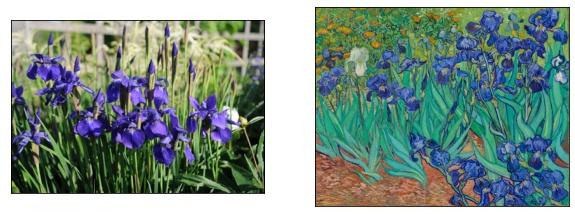

In [0]:
print('Input photo and style')
output = [load_process_img(content), load_process_img(style)]
plt.figure(figsize=(10,10))
for i in range(2):
  plt.subplot(1,2,i+1)
  display_img(output[i])
plt.show()

In [0]:
content_layer = 'block5_conv2'
style_layers = ['block1_conv1', 'block3_conv1', 'block5_conv1']
content_model = Model(
    inputs = model.input,
    outputs = model.get_layer(content_layer).output
)

style_models = [Model(inputs = model.input,
                      outputs = model.get_layer(layer).output) for layer in style_layers]

In [0]:
def content_cost(content, generated):
  return tf.reduce_mean(tf.square(content_model(content)- content_model(generated)))

In [0]:
def gram_matrix(A):
  a = tf.reshape(A, [-1, int(A.shape[-1])])
  G = tf.matmul(a, a, transpose_a= True)
  return G/tf.cast(tf.shape(a)[0], tf.float32)

In [0]:
def style_cost(style, generated):
  J_style = 0
  for style_model in style_models:
    gram_matr = gram_matrix(style_model(style))-gram_matrix(style_model(generated))
    current_loss = tf.reduce_mean(tf.square(gram_matr))
    J_style += current_loss/len(style_models)

  return J_style

In [0]:
def train_model(content_path, style_path, iteration = 20, alpha = 10., beta = 20.):
  content  = load_process_img(content_path)
  style = load_process_img(style_path)

  generated = tf.Variable(content, dtype=tf.float32)
  opt = tf.optimizers.Adam(learning_rate = 7.)
  best_cost = 1e12 +0.1
  best_img = None
  start_time = time.time()
  for i in range(iteration):
    with tf.GradientTape() as tape:
      J_content = content_cost(content, generated)
      J_style = style_cost(style, generated)
      J_total = alpha + J_content + beta * J_style

    grads = tape.gradient(J_total, generated)
    opt.apply_gradients([(grads, generated)])
 
    if J_total < best_cost:
      best_cost = J_total
      best_img = generated.numpy()

    if i%25 ==0:
      print('Cost at {}: {}. Time elapsed: {}'.format(i, J_total, time.time()-start_time))
    generated_images.append(generated.numpy())

  return best_img

In [50]:
generated_images = []
best_img = train_model(content, style, iteration=200)

Cost at 0: 7731378176.0. Time elapsed: 9.0841383934021
Cost at 25: 95529832.0. Time elapsed: 62.95725059509277
Cost at 50: 28769498.0. Time elapsed: 116.71122241020203
Cost at 75: 17418138.0. Time elapsed: 170.46511244773865
Cost at 100: 13365198.0. Time elapsed: 224.23507452011108
Cost at 125: 11232373.0. Time elapsed: 277.8820035457611
Cost at 150: 9826419.0. Time elapsed: 331.59036016464233
Cost at 175: 8776732.0. Time elapsed: 385.2980945110321


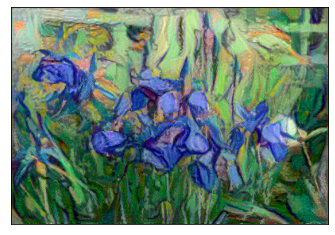

In [51]:
images = best_img
display_img(images)

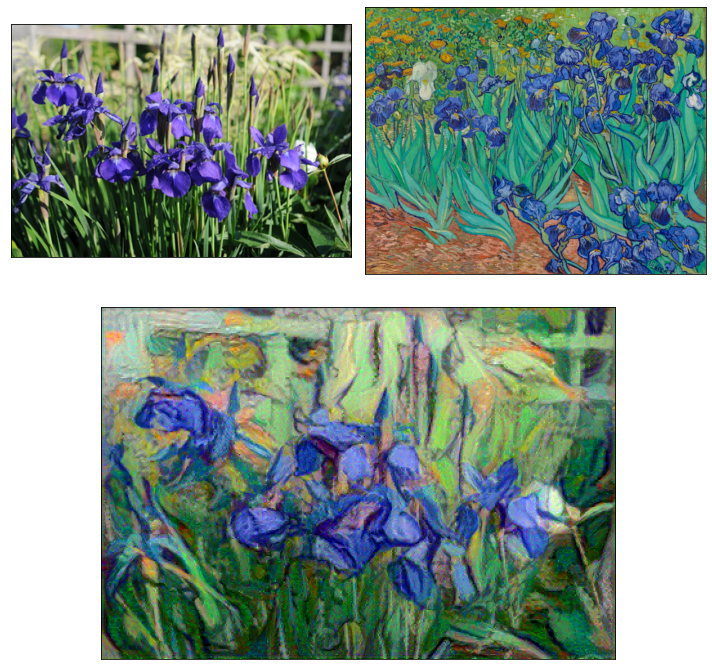

In [53]:
import matplotlib.gridspec as gridspec

output = [load_process_img(content), load_process_img(style), best_img]
fig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(2, 2)

ax = plt.subplot(gs[0, 0]) 
display_img(output[0])

ax = plt.subplot(gs[0, 1]) 
display_img(output[1])

ax = plt.subplot(gs[1, :])
display_img(output[2])

fig.tight_layout()
plt.show()